# Coding Task

## Table of Contents
- Generating the Dataset
    - Generating the demographic information
    - Generating the attitudes towards vaccination
    - Generating the underlying social network
    - Generating the treatment status
    - Generating the outcome variable
- Conducting the Analysis

### Importing Needed libraries
This notebook assumes that the working directory is the root of the project folder. Otherwise, change the directory using `os.chdir()`.

In [171]:
# Importing libraries
import numpy as np
import pandas as pd
import networkx as nx
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity, manhattan_distances
from sklearn.cluster import SpectralClustering


# Set random seed for reproducibility
np.random.seed(111)

### Generating Demographic Information

In [172]:
# Initialize an empty dataframe with 5000 rows
n = 5000 # number of samples to generate
demographics_df = pd.DataFrame(index=range(n))

# Generate demographic data
demographics_df['demographic_age'] = np.round(np.random.uniform(21,80,n)).astype('int')
demographics_df['demographic_income'] = (1 - np.random.power(2.5,n)) * 5000000
demographics_df['demographic_education'] = np.round(np.random.uniform(0,3,n)).astype('int')
demographics_df['demographic_unobs_grp'] = np.random.choice(['A','B','C','D','E'],n)

demographic_cont_vars = ['demographic_age','demographic_income','demographic_education']
demographic_cat_vars = 'demographic_unobs_grp'

### Generating Attitudes Towards Vaccination

In [173]:
def generate_attitudes(df):
    # Normalize continuous variables
    this_df = df.copy(deep=True)
    this_df[demographic_cont_vars] = this_df[demographic_cont_vars].apply(lambda x: x/x.max(), axis=0)

    # Dummy categorical variables
    this_df = pd.get_dummies(this_df,columns=[demographic_cat_vars],drop_first=False)

    # Generate attitudes
    attitudes = ['att_covid','att_vaccine','att_safety','att_unobserved']
    attitudes_df = pd.DataFrame(index=range(n))
    demographics = list(this_df.columns)

    for attitude in attitudes:
        attitudes_df[attitude] = np.random.choice(range(4,7),n) + np.random.normal(0,1,n)
        for demographic in demographics: # Add influence of demographics
            attitudes_df[attitude] = attitudes_df[attitude] + np.random.uniform(-0.25,0.25) * this_df[demographic]

        # Handle values that are outside of max range (1-10)
        attitudes_df[attitude] = attitudes_df[attitude].clip(1,10)

        # Round
        attitudes_df[attitude] = np.round(attitudes_df[attitude]).astype('int')
    return attitudes_df

attitudes_df = generate_attitudes(demographics_df)
print(demographics_df.shape)
demographics_df.head(1)

(5000, 4)


,demographic_age,demographic_income,demographic_education,demographic_unobs_grp
0,57,1.527737e+06,3,A


### Generating Network Structure

In [174]:
class diffusion_network:
    """
    This class will generate a network based on a population's demographic information or an existing edgelist.
    Arguments:
    ===========
    demographics_df: pd.Dataframe
        Denotes the demographic attributes to generate a dataframe on. Can have as many columns as needed
    edgelist: pd.Dataframe
        A two-column dataframe denoting the network edgelist
    num_nodes: int
        How many nodes that network generated from demographics should have. Must be equal to the number of rows in demographics_df.
    edges_per_node: int
        How many edges each node should have when it enters the network.
    n_communities: int
        The number of communities in the network.
    community_strength: int
        Denotes the increased likelihood of a node connecting to an in-community node relative to out-community node.
        For example, community_strength=100 denotes that every node is 100x more likely to connect to a node in its same community.

    """
    def __init__(self, demographics_df=None,edgelist=None,num_nodes:int=5000,edges_per_node:int=10,n_communities:int=50,community_strength:int=1000):
        # Initialize the network structure either from an edgelist or a population's demographic information
        if demographics_df is None and edgelist is None: 
            raise Exception("Specify how the network should be generated")
        elif demographics_df is not None and edgelist is not None:
            raise Exception("Please only input demographic information or and edgelist, not both.")
        elif demographics_df is not None:
            self.G = self.generate_network_from_demographic(demographics_df,num_nodes,edges_per_node,n_communities,community_strength)
        elif edgelist is not None:
            self.G = self.import_edgelist(edgelist)

        """Initialize the node attributes for diffusion"""
        # Generate and validate network adjacency matrix
        self.adj_matrix = nx.to_numpy_array(self.G)
        assert self.adj_matrix.shape[0] == self.adj_matrix.shape[1]

        # Normalize adjacency matrix to get the mean influence weight of each node
        row_sums = self.adj_matrix.sum(axis=1, keepdims=True)
        self.normalized_adj_matrix = self.adj_matrix / row_sums
        """
        # Check that the network structure has an eventual stable state (i.e. all eigenvalues >= 1 are not complex numbers)
        self.eigvals, self.eigvecs = np.linalg.eig(self.normalized_adj_matrix) 
        self.signf_eigvals = np.abs(self.eigvals) > 0.999
        isreal_eigvals = np.isreal(self.eigvals)
        if not np.array_equal(np.logical_and(self.signf_eigvals,isreal_eigvals), self.signf_eigvals):
            raise Exception("This network has no stable state. Please regenerate the network.")
        """


    def generate_network_from_demographic(self,demographics_df:pd.DataFrame,num_nodes,edges_per_node,n_communities,community_strength,diagnostic_plots=True):
        """Generate a Bianconi-Barabási network based on Homophily"""
        # Dummy categorical variables (if applicable)
        demographics_df = pd.get_dummies(demographics_df,columns=[demographic_cat_vars],drop_first=False)

        # Create 10 communities based on demographic information
        demographics_df = demographics_df/np.sqrt(demographics_df.var(axis=0))
        cluster_model = SpectralClustering(n_clusters=n_communities, random_state=100)
        cluster_model.fit(demographics_df)
        community = cluster_model.labels_

        # Generate similarity matrix based on if nodes are in same community
        demographic_similarity = np.ones((len(community),len(community)))
        for i in range(0,len(community)):
            for j in range(0,len(community)):
                if community[i] == community[j]:
                    demographic_similarity[i,j] = community_strength # 10x likelihood of an edge if in same community

        #demographic_similarity = 1/(np.log(manhattan_distances(demographics_df) + 1) + 1)
        #demographic_similarity = manhattan_distances(demographics_df)
        if diagnostic_plots:
            print(demographic_similarity)
            plt.hist(demographic_similarity.flatten(),bins=50)
            plt.xlabel('Similarity Score')
            plt.title('Distribution of similarity scores')
            plt.ylabel('Frequency')
            plt.yscale('log')
            plt.grid(True)
            plt.show()
    
        def bb_network(N, m): # Generate a Bianconi–Barabási network
            # 1. Start with a clique of m+1 nodes
            G = nx.complete_graph(m + 1)

            for i in range(G.number_of_nodes(), N):
                # 2. Select m different nodes at random, weighted by their similarity and number of existing ties.
                new_neighbors = []
                possible_neighbors = list(G.nodes)
                weight = [demographic_similarity[i,j] * G.degree(j) for j in possible_neighbors]
                p = np.array(weight)/np.sum(np.array(weight))
                new_neighbors = np.random.choice(possible_neighbors, size=m, replace=False, p=p)

                # 3. Add a new node i and link it with the m nodes from the previous step.
                for j in new_neighbors:
                    G.add_edge(i, j)
            return G
        
        G = bb_network(num_nodes,edges_per_node)

        # Print Network Diagnostic Information:
        print('\033[92m Network Generation Successful')
        print('\033[92m Number of Nodes:',G.number_of_nodes())
        print("\033[92m Number of Edges:",G.number_of_edges())
        print("\033[92m Average Clustering:",nx.average_clustering(G))

        if diagnostic_plots: # Plot Network Degree Distribution
            degree_dist = list(dict(G.degree).values())
            generate_log_bin = lambda data: np.logspace(np.log10(np.min(data)), np.log10(np.max(data)), 20)
            plt.hist(degree_dist,bins=generate_log_bin(degree_dist))
            plt.title('Degree distribution of network')
            plt.xlabel('Degree centrality')
            plt.ylabel('Frequency')
            plt.xscale('log')
            plt.yscale('log')
            plt.show()
        return G

    """Implement Importing Functions to Import and Export to Nodelist"""
    def import_edgelist(self,edgelist:pd.DataFrame):
        return nx.from_pandas_edgelist(edgelist)
    
    def export_edgelist(self,filename:str='edgelist.csv'):
        edgelist = nx.to_pandas_edgelist(self.G)
        edgelist.columns = ['source', 'target']
        edgelist.to_csv(filename,index=False)
        return None
        

    """Implement Diffusion of Ideas Along Network"""
    def run_diffusion_round(self,node_values,delta_last=0): # Run diffusion until the opinion change each round if too small to shift someone's opinion by even 1 point
    
        new_node_values = np.round(np.dot(self.normalized_adj_matrix,node_values)).astype('int')
        delta = np.sum(np.abs(new_node_values - node_values))
        if delta < 1:
            return new_node_values
        else: # Call itself again if the network is still changing
            return self.run_diffusion_round(new_node_values,delta)

    def run_diffusion(self, node_values): # Run the diffusion of a vaccine attitude
        assert self.adj_matrix.shape[1] == node_values.shape[0] # Validate of input vector shape

        # Change the network's initial condition to be written in terms of the eigenbasis
        initial_condition = np.real(np.linalg.solve(self.eigvecs,node_values))
        plt.hist(initial_condition)

        initial_condition = self.signf_eigvals * initial_condition

        # Solve for the network's eventually stable state
        steady_state = np.sum((self.eigvecs * initial_condition)[:,np.argwhere(self.signf_eigvals)],axis=1)
        return steady_state

[[1000.    1.    1. ...    1.    1.    1.]
 [   1. 1000.    1. ...    1.    1.    1.]
 [   1.    1. 1000. ...    1.    1.    1.]
 ...
 [   1.    1.    1. ... 1000.    1.    1.]
 [   1.    1.    1. ...    1. 1000.    1.]
 [   1.    1.    1. ...    1.    1. 1000.]]


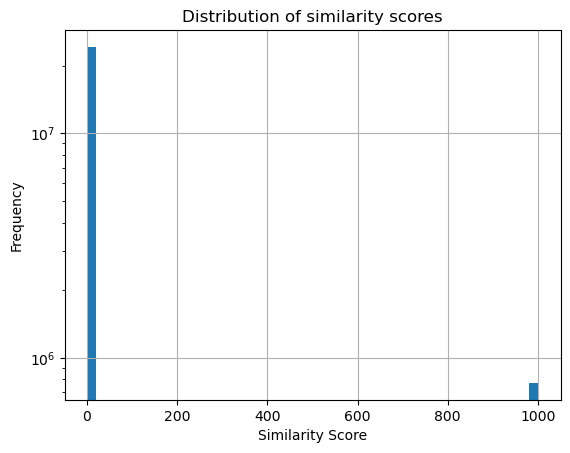

 Network Generation Successful
 Number of Nodes: 5000
 Number of Edges: 49945
 Average Clustering: 0.253539975448908


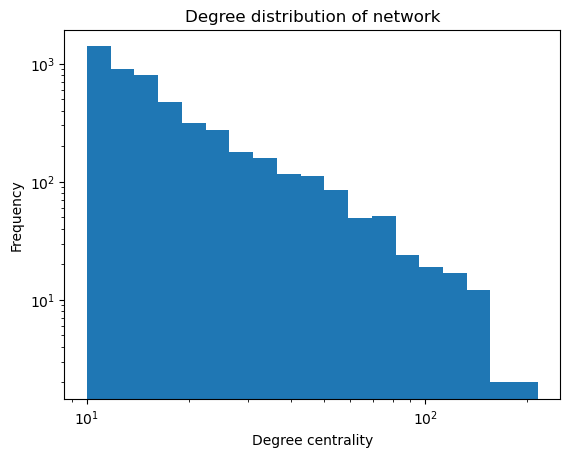

In [175]:
this_network = diffusion_network(pd.merge(attitudes_df,demographics_df,how='inner',left_index=True,right_index=True))

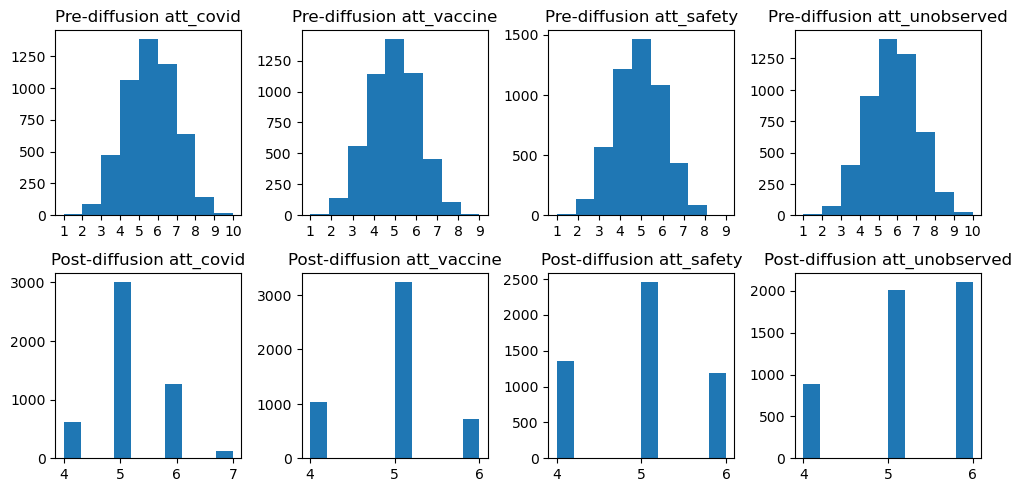

In [176]:
fig, ax = plt.subplots(nrows=2,ncols=4,squeeze=False,figsize=(10,5))
for i, attitude in enumerate(attitudes_df.columns):

    # Plot distribution of pre diffusion values
    ax[0,i].hist(attitudes_df[attitude],bins=9)
    ax[0,i].set_title('Pre-diffusion ' + str(attitude))
    ax[0,i].xaxis.set_major_locator(MaxNLocator(integer=True))

    # Plot distribution of post diffusion values
    attitudes_df[attitude] = this_network.run_diffusion_round(attitudes_df[attitude])
    ax[1,i].hist(attitudes_df[attitude])
    ax[1,i].set_title('Post-diffusion ' + str(attitude))
    ax[1,i].xaxis.set_major_locator(MaxNLocator(integer=True))
fig.tight_layout(pad=1.0)
plt.show()

Export edgelist and nodelist to csv for Gephi

In [ ]:
this_network.export_edgelist(filename='figures/gephi/edgelist.csv')
nodelist = attitudes_df['att_safety']
nodelist.index.name = 'id'
nodelist.to_csv('figures/gephi/nodelist.csv')

Export network edgelist

In [179]:
this_network.export_edgelist(filename='data/edgelist.csv')

Export pre-treatment survey to csv

In [180]:
pre_treatment_df = pd.merge(attitudes_df,demographics_df,how='inner',left_index=True,right_index=True)
pre_treatment_df.to_csv('data/pre_treatment.csv')

## Model Treatment Effects

## Post-Simulation Analysis 

Clear data cache and re-import packages

In [ ]:
% reset -f